# Отток клиентов

Из компании стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

***Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.*** Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:
<br>RowNumber — индекс строки в данных
<br>CustomerId — уникальный идентификатор клиента
<br>Surname — фамилия
<br>CreditScore — кредитный рейтинг
<br>Geography — страна проживания
<br>Gender — пол
<br>Age — возраст
<br>Tenure — количество недвижимости у клиента
<br>Balance — баланс на счёте
<br>NumOfProducts — количество продуктов банка, используемых клиентом
<br>HasCrCard — наличие кредитной карты
<br>IsActiveMember — активность клиента
<br>EstimatedSalary — предполагаемая зарплата
<br>Целевой признак:
<br>Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
# Загрузка библиотек
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter('ignore')

In [2]:
data=pd.read_csv('/datasets/Churn.csv')
data.head(7)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0


In [3]:
# Проверка типов данных
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
#Уникальные значения столбца
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Выявлено 9% нулевых значений в столбце "Tenure"- заменим их на 0.

In [5]:
#Замена nan на медиану
data = data.replace(np.nan, 0)

In [7]:
# Статистические данные по перечню столбцов df
columns = data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
data_stat = pd.DataFrame(columns)
data_stat.describe().astype('int')

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000,10000,10000,10000,10000,10000
mean,650,38,4,76485,1,100090
std,96,10,3,62397,0,57510
min,350,18,0,0,1,11
25%,584,32,2,0,1,51002
50%,652,37,4,97198,1,100193
75%,718,44,7,127644,2,149388
max,850,92,10,250898,4,199992


### Вывод:
Выборка сохранена и проверена на предмет пропусков, нулевых данных и корректности типов данных, для формирования модели является корректной.
Добавлены справочные статистические характеристики по методу describe() для полной картины.

В исследуемой выборке data есть 2 категориальных признака (столбцы 'Geography' и 'Gender'), которые переводим в численные техникой OHE (One-Hot Encoding), также масштабируем данные с помощью StandardScaler(). 
<br>Делим данные выборки на обучающую, валидационную и тестовую выборку.

In [8]:
# Удаление столбца "Surname", "RowNumber", "CustomerId" для корректного обучения моделей
data_exited =  data.drop(['Surname', 'RowNumber', 'CustomerId'], axis = 1)

In [9]:
data_exited['Geography'].value_counts() #проверка количества классов по каждой категории

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [10]:
data_exited['Gender'].value_counts() 

Male      5457
Female    4543
Name: Gender, dtype: int64

In [11]:
# Преобразование категориальных признаков в численные
data_ohe = pd.get_dummies(data_exited, drop_first= True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
# Отделение по 20% данных для валидационной и тестовой выборок, на обучающую- 60%
features = data_ohe.drop(['Exited'], axis=1) #признаки
target = data_ohe['Exited'] #целевой признак

In [13]:
# Цикл для деления df
def train_test_valid_split(features, target, test_size=0.2, valid_size=0.2):
    
    features_train, features_test, target_train, target_test = train_test_split(
        features,
        target,
        stratify=target,
        test_size=test_size
    )
 
    post_split_valid_size = valid_size / (1 - test_size)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features_train,
        target_train,
        stratify=target_train,
        test_size=post_split_valid_size
    )
    
    return features_train, features_test, features_valid, target_train, target_test, target_valid

In [14]:
features_train, features_test, features_valid, target_train, target_test, target_valid =(
    train_test_valid_split(features, target) )

In [15]:
# Проверка на корректность разбиения выборок train, valid, test (60%-20%-20%)
features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape

((6000, 11), (2000, 11), (2000, 11), (6000,), (2000,), (2000,))

In [16]:
# Перечень столбцов df для стандартизации
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [17]:
# Масштабирование значений в df
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
# Преобразование выборок
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

#print(features_train.head())
#print(features_test.head())

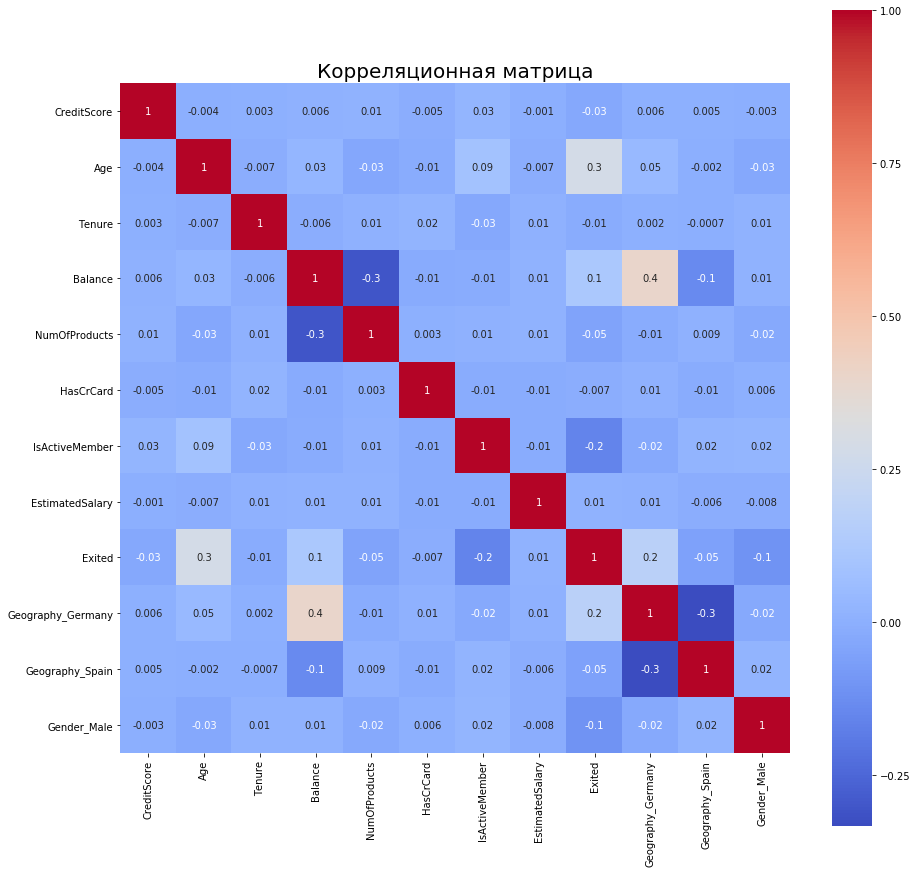

In [19]:
corr = data_ohe.corr()
plt.figure(figsize = (15, 15))
sns.heatmap(corr, vmax = 1, square = True, annot = True, cmap ='coolwarm', fmt='.1g')
plt.title('Корреляционная матрица', size = 20)
plt.show()

Матрица корреляции показвает невысокий уровень - до 0.4, таким образом все числовые параметры выборки будут участвовать при исследовании модели.  

### Вывод: 
Данные выборки подготовлены для исследования: преобразование категориальных признаков в численные универсальным методом One-Hot Encoding, проведено масштабирование данных, проверка матрицей корреляции, а также деление выборки на обучающую, валидационную и тестовую (3:1:1).

# 2. Исследование задачи

Исследуем баланс классов, обучим модель без учёта дисбаланса.
В исследовании задачи участвуют 3 модели: RandomForestClassifier, GradientBoostingClassifier, DecisionTreeClassifier.

In [20]:
# Функция расчета оптимального гиперпараметра max_depth
def hyperparam(model_type, low, high, step):
    train = []
    valid = []
    f1 = []
    
    for hyperp in range(low, high, step):
        model = model_type(random_state = 12345,  max_depth = hyperp)
        model.fit(features_train, target_train)
    
        predict_train = model.predict(features_train)
        accuracy_train = accuracy_score(target_train, predict_train)
        train.append(accuracy_train)
    
        predictions_valid = model.predict(features_valid)
        accuracy_valid = accuracy_score(target_valid, predictions_valid)
        valid.append(accuracy_valid)
        
        f1_value = f1_score(target_valid, predictions_valid)
        f1.append(f1_value)
        
    results= pd.DataFrame([train, valid, f1],
                           columns = range(low,high,step)).T.reset_index()                        
                           
    results.columns = ['depth', 'accuracy train', 'accuracy valid', 'f1 score']
    
    return results

In [21]:
# Построение графика accuracy и f1_score 
def plot_results (data, low, high, title):
    x = data['depth']
    y = data['accuracy train']
    z = data['accuracy valid']
    k = data['f1 score']
    plt.figure(figsize=(15,5))
    plt.xlim(low,high)
    plt.ylim(data['f1 score'].min(),1)
    plt.xlabel('depth')
    plt.ylabel('accuracy, f1_score')
    plt.plot(x, y, color='gray', label = 'accuracy train', linestyle = '--', marker = 'o')
    plt.plot(x, z, color ='red', label = 'accuracy valid', marker = '*')
    plt.plot(x, k, color='blue', label = 'f1 score', marker = 'v')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

In [22]:
features_train.dtypes

CreditScore          float64
Age                  float64
Tenure               float64
Balance              float64
NumOfProducts        float64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Male            uint8
dtype: object

In [23]:
# Применяем функцию перебора гиперпараметра для RandomForest
rf = hyperparam(RandomForestClassifier, 1, 21, 1)

rf

,depth,accuracy train,accuracy valid,f1 score
0,1,0.796333,0.7960,0.000000
1,2,0.809000,0.8160,0.189427
2,3,0.818167,0.8255,0.268344
3,4,0.849667,0.8570,0.515254
4,5,0.856000,0.8555,0.520730
5,6,0.860667,0.8610,0.550162
6,7,0.869167,0.8580,0.547771
7,8,0.879500,0.8635,0.575428
8,9,0.888000,0.8625,0.574961
9,10,0.901667,0.8630,0.578462


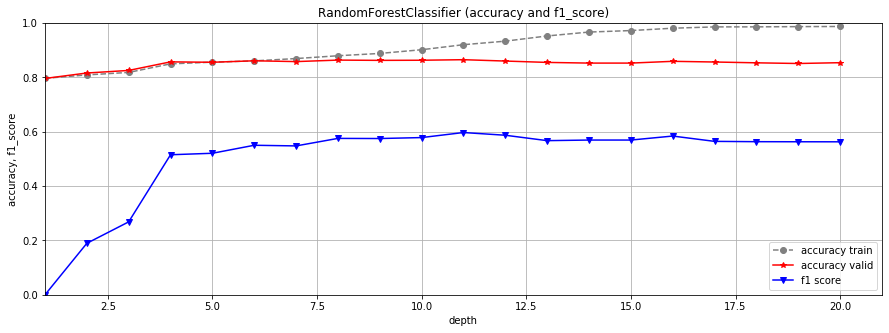

In [24]:
plot_results(rf, 1,21, 'RandomForestClassifier (accuracy and f1_score)')

In [25]:
best_rf = RandomForestClassifier(random_state = 12345, max_depth = 7)
best_rf.fit(features_train, target_train)

predictions_valid_rf = pd.Series(best_rf.predict(features_valid))

In [26]:
# Матрица RandomForestClassifier
confusion_matrix_rf= confusion_matrix(target_valid,predictions_valid_rf)

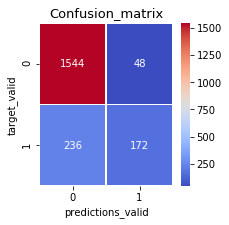

In [27]:
f, ax=plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix_rf,annot=True,linewidths=0.5,cmap ='coolwarm',fmt=".0f",ax=ax)
plt.xlabel("predictions_valid")
plt.ylabel("target_valid")
plt.title('Confusion_matrix', size = 13)
plt.show()

In [28]:
# Метрика полноты RandomForestClassifier
recall_rf= recall_score(target_valid,predictions_valid_rf)
recall_rf

0.4215686274509804

In [29]:
# Метрика точности RandomForestClassifier
precision_rf = precision_score(target_valid,predictions_valid_rf)
precision_rf

0.7818181818181819

### Вывод:
Сопоставление accuracy выборок test-valid по модели RandomForestClassifier отражает момент расхождения их векторов на уровне max_depth = 7 (accuracy valid- 85.80%), что свидетельствует о начале переобучения модели. Метрика f1_score на этом уровне- 0.53.

In [30]:
# Применяем функцию перебора гиперпараметра для GradientBoosting
gb = hyperparam(GradientBoostingClassifier, 1, 11, 1)

gb

,depth,accuracy train,accuracy valid,f1 score
0,1,0.853833,0.8570,0.534202
1,2,0.865500,0.8685,0.597243
2,3,0.874667,0.8715,0.611195
3,4,0.885667,0.8695,0.612184
4,5,0.902833,0.8710,0.621701
5,6,0.929833,0.8680,0.619597
6,7,0.967167,0.8595,0.602546
7,8,0.993500,0.8580,0.603352
8,9,1.000000,0.8570,0.600559
9,10,1.000000,0.8555,0.586552


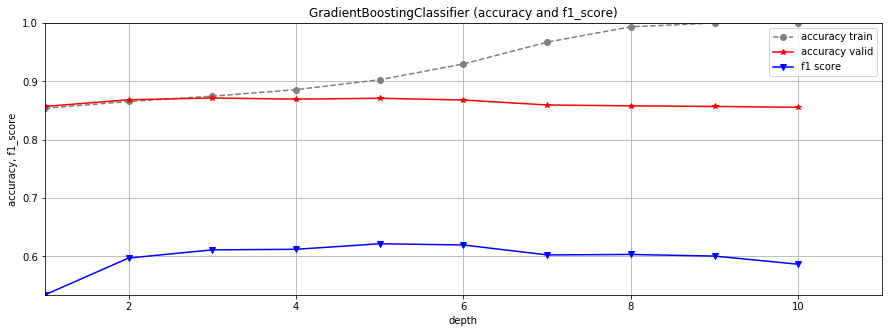

In [31]:
plot_results(gb, 1,11, 'GradientBoostingClassifier (accuracy and f1_score)')

In [32]:
best_gb =  GradientBoostingClassifier(random_state = 12345, max_depth = 3)
best_gb.fit(features_train, target_train)

predictions_valid_gb = pd.Series(best_gb.predict(features_valid))

In [33]:
confusion_matrix_gb= confusion_matrix(target_valid,predictions_valid_gb)

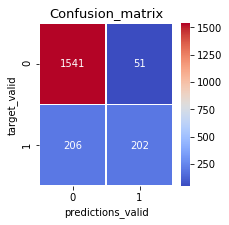

In [34]:
f, ax=plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix_gb,annot=True,linewidths=0.5,cmap ='coolwarm',fmt=".0f",ax=ax)
plt.xlabel("predictions_valid")
plt.ylabel("target_valid")
plt.title('Confusion_matrix', size = 13)
plt.show()

In [35]:
recall_gb= recall_score(target_valid,predictions_valid_gb)
recall_gb

0.4950980392156863

In [36]:
precision_gb = precision_score(target_valid,predictions_valid_gb)
precision_gb

0.7984189723320159

### Вывод:
Сопоставление accuracy выборок test-valid  по модели GradientBoostingClassifier отражает момент расхождения их векторов на уровне max_depth = 3 (accuracy valid- 86.30%), что свидетельствует о начале переобучения модели. Метрика f1_score на этом уровне- 0.58.

In [37]:
# Применяем функцию перебора гиперпараметра для DecisionTree
dt = hyperparam(DecisionTreeClassifier, 1, 18, 1)

dt

,depth,accuracy train,accuracy valid,f1 score
0,1,0.796333,0.7960,0.000000
1,2,0.826000,0.8330,0.534819
2,3,0.842500,0.8395,0.415301
3,4,0.850667,0.8535,0.547141
4,5,0.857500,0.8560,0.554180
5,6,0.865333,0.8620,0.586826
6,7,0.871333,0.8595,0.584934
7,8,0.882833,0.8610,0.605114
8,9,0.895000,0.8520,0.591160
9,10,0.909500,0.8435,0.571819


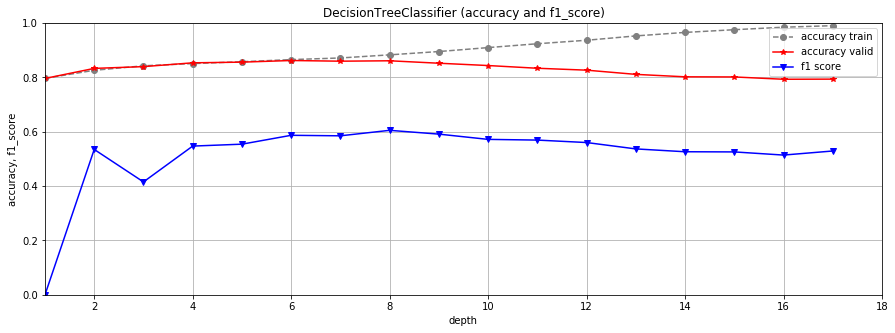

In [38]:
plot_results(dt, 1,18, 'DecisionTreeClassifier (accuracy and f1_score)')

In [39]:
best_dt =  DecisionTreeClassifier(random_state = 12345, max_depth = 6)
best_dt.fit(features_train, target_train)

predictions_valid_dt = pd.Series(best_dt.predict(features_valid))

In [40]:
confusion_matrix_dt= confusion_matrix(target_valid,predictions_valid_dt)

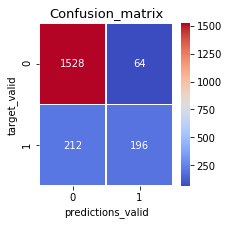

In [41]:
f, ax=plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix_dt,annot=True,linewidths=0.5,cmap ='coolwarm',fmt=".0f",ax=ax)
plt.xlabel("predictions_valid")
plt.ylabel("target_valid")
plt.title('Confusion_matrix', size = 13)
plt.show()

In [42]:
recall_dt= recall_score(target_valid,predictions_valid_dt)
recall_dt

0.4803921568627451

In [43]:
precision_dt = precision_score(target_valid,predictions_valid_dt)
precision_dt

0.7538461538461538

### Вывод:
Сопоставление accuracy выборок test-valid по модели DecisionTreeClassifier отражает момент расхождения их векторов на уровне max_depth = 6 (accuracy valid- 85.40%), что свидетельствует о начале переобучения модели. Метрика f1_score на этом уровне- 0.52.

Проверим рассматриваемые модели на адекватность с помощью DummyClassifier- модели корректны.

In [44]:
#Метод value_counts с аргументом normalize=True показывает, что выборка несбалансирована
data_ohe['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [45]:
x=data_ohe['Exited'].value_counts(normalize=True)

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(features_train, target_train)
DummyClassifier(strategy='most_frequent')
dummy_model.predict(features_test)
x
dummy_model.score(features_train, target_train)

0.7963333333333333

### Вывод:
Сравнение результатов по моделям с DummyClassifier при условии, что выборка несбалансирована (класс 0-1: 0.80-0.20), подтвердило их адекватность. Все рассматриваемые модели по показателю accuracy (train/ valid) превышают 0.80. На данном этапе наилучшие метрики принадлежат модели GradientBoostingClassifier.

# 3. Борьба с дисбалансом

Улучшение качества модели, учитывая дисбаланс классов. Обучение разных моделей и поиск лучшей.

Придадим объектам редкого класса исследуемых моделей больший вес с помощью гиперпараметра class_weight='balanced'. 
<br>Исключением является GradientBoostingClassifier- учитывая характеристики модели нет необходимости вводить параметр 'class_weight'. 

In [46]:
# Обучение модели при сбаланстрованном весе классов RandomForestClassifier
best_rf = RandomForestClassifier(random_state = 12345, n_estimators = 30, max_depth = 7,class_weight='balanced')
best_rf.fit(features_train, target_train)

predictions_valid_rf = pd.Series(best_dt.predict(features_valid))
print("f1_score:", f1_score(target_valid, predictions_valid_rf))

f1_score: 0.5868263473053892


In [47]:
# Обучение модели DecisionTreeClassifier
best_dt = DecisionTreeClassifier(random_state = 12345, max_depth = 6, class_weight='balanced')
best_dt.fit(features_train, target_train)

predictions_valid_dt = pd.Series(best_dt.predict(features_valid))
print("f1_score:", f1_score(target_valid, predictions_valid_dt))

f1_score: 0.5805243445692884


### Вывод:
В модели RandomForestClassifier с гиперпараметрами {n_estimators = 30, max_depth = 7} метрика f1_score достигла значение в 0.52, в DecisionTreeClassifier- 0.56 при {max_depth = 6}.

Увеличиваем выборку техникой 'upsampling', чтобы объекты редкого класса не были такими редкими в данных.
<br>И уменьшаем техникой 'downsampling', чтобы объекты частого класса не были такими частыми.

In [48]:
# Функция для увеличение выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# Применение функции увеличения выборки
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [49]:
# Обучение модели с увеличенной выборкой RandomForestClassifier
upsampled_rf = RandomForestClassifier(random_state = 12345, n_estimators = 30, max_depth = 7, class_weight='balanced')
upsampled_rf.fit(features_upsampled, target_upsampled)
predicted_valid_upsampled_rf = upsampled_rf.predict(features_valid)

print("f1_score:", f1_score(target_valid, predicted_valid_upsampled_rf))

f1_score: 0.6085192697768762


In [50]:
# Обучение модели с увеличенной выборкой DecisionTreeClassifier
upsampled_dt = DecisionTreeClassifier(random_state = 12345, max_depth = 6, class_weight='balanced')
upsampled_dt.fit(features_upsampled, target_upsampled)
predicted_valid_upsampled_dt = upsampled_dt.predict(features_valid)

print("f1_score:", f1_score(target_valid, predicted_valid_upsampled_dt))

f1_score: 0.5805243445692884


In [51]:
# Функция для уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]) 
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

# Применение функции уменьшения выборки
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [52]:
# Обучение модели с уменьшенной выборкой RandomForestClassifier
downsampled_rf = RandomForestClassifier(random_state = 12345, n_estimators = 30, max_depth = 7, class_weight='balanced')
downsampled_rf.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_rf = downsampled_rf.predict(features_valid)

print("f1_score:", f1_score(target_valid, predicted_valid_downsampled_rf))

f1_score: 0.5418326693227091


In [53]:
# Обучение модели с уменьшенной выборкой DecisionTreeClassifier
downsampled_dt = DecisionTreeClassifier(random_state = 12345, max_depth = 6, class_weight='balanced')
downsampled_dt.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_dt = downsampled_dt.predict(features_valid)

print("f1_score:", f1_score(target_valid, predicted_valid_downsampled_dt))

f1_score: 0.5496974935177181


### Вывод:
В результате борьбы с дисбалансом f1_score имеет следующие метрики по техникам:
<br>'upsampled'~
<br>RandomForestClassifier- 0.58, DecisionTreeClassifier- 0.56
<br>'downsampled'~
<br>RandomForestClassifier- 0.54, DecisionTreeClassifier- 0.51

# 4. Тестирование модели

Проведем финальное тестирование лучшей модели RandomForestClassifier.

In [54]:
# Тестирование модели RandomForestClassifier
best_rf = RandomForestClassifier(random_state = 12345, n_estimators = 30, max_depth = 7,class_weight='balanced')
best_rf.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [55]:
predictions_test = pd.Series(best_rf.predict(features_test))
print(f1_score(target_test, predictions_test))

0.6333333333333333


In [56]:
# Частота классов модели
class_best_rf = predictions_test.value_counts(normalize = True) 
print(class_best_rf)

0    0.7235
1    0.2765
dtype: float64


### Вывод:
На тестовой выборке f1_score равен 0.62, требование задания "не менее 0.59" соблюдено.

Изменение значения порога проверяется расчетом функции predict_proba()- предсказание вероятности по каждому объекту: строки- объекты, первый столбец- вероятность отрицательного класса, а второй — положительная.
<br>Наглядно данная метрика продемонстрирована на графиках 'PR-кривая' и 'ROC-кривая'.

In [57]:
#Расчет вероятности классов
probabilities_test = best_rf.predict_proba(features_test)
print(probabilities_test [:5])

[[0.82937864 0.17062136]
 [0.71498971 0.28501029]
 [0.85418064 0.14581936]
 [0.77393294 0.22606706]
 [0.71546163 0.28453837]]


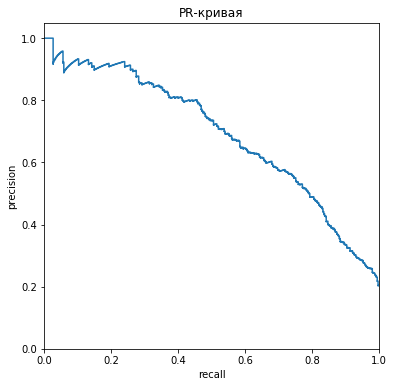

In [58]:
#Кривая PR
pr_test = best_rf.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, pr_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR-кривая')
plt.show()

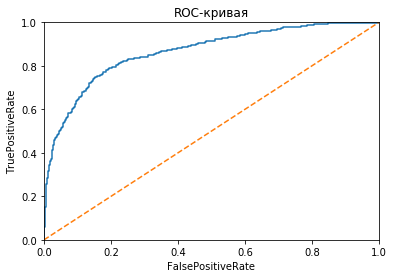

0.8646072883361018


In [59]:
# Кривая ROC_AUC
roc_auc_test = best_rf.predict_proba(features_test)
roc_auc_one_test = roc_auc_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, roc_auc_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FalsePositiveRate')
plt.ylabel('TruePositiveRate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, roc_auc_one_test)

print(auc_roc)

### Вывод:
RandomForestClassifier выбрана в качестве лучшей модели обоснованно: метрика precision_recall_curve- имеет положительную динамику (чем выше PR-кривая, тем лучше модель); roc_auc_score- площадь под кривой 0.87- чем график выше, тем больше значение TPR и лучше качество модели (больше 0.5- roc_auc_score случайной модели); присутствует несбалансированность классов- расчитана с помощью функции predict_proba().

In [60]:
print(classification_report(target_test, predictions_test))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1593
           1       0.55      0.75      0.63       407

    accuracy                           0.82      2000
   macro avg       0.74      0.80      0.76      2000
weighted avg       0.85      0.82      0.83      2000

